# Using Genex to identify marker genes

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')


In [2]:
#import os
#os.chdir("/content/drive/My Drive/BIOML/HIMANI")

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC, SVC
from genex.filters.embedded import EmbeddedFilter
from genex.filters.mrmr import MRMRP
from genex.utils.help_functions import model_based_relevance, auc_relevance, load_DEGs
from sklearn.feature_selection import RFE,RFECV, SelectKBest, f_classif,SelectKBest, mutual_info_classif,chi2
from genex.eval.evaluate import do_train_test
from genex.eval.cross_validation import  do_cross_validation_with_feature_selection,do_cross_validation

%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib inline

#from matplotlib.pyplot import plt
import seaborn as sns
import warnings

# Comment these lines if you are not using Mac OS
import matplotlib as mpl
#mpl.use('MacOSX')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set random seed
seed = 7
np.random.seed(seed)

## Inputs and parameters

In [2]:
# ========== INPUTS ==========

mydata = 'GSE205450_norm'


data_file = './data/'+ mydata +'.csv'

deg_lf_file = './data/'+ mydata +'_DEGS.csv'
degs_file = './data/'+ mydata +'_DEGS.txt'   # If None, all genes will be considered.
out_file = './results/'+ mydata +'/fs_scores.csv'

is_save_results = True

# data pre-processing
is_normalize_samples = False
is_normalize_columns = True
norm_filter = MinMaxScaler()

# experiment
num_folds = 5 #2
num_runs = 5  #2
label = 'disease'

# feature selection
# num_features = 10 #20
# fsm = MRMRP(relevance_func= auc_relevance, redundancy_func=stats.pearsonr, num_features=num_features)

models = {
    "LinearSVC": LinearSVC(),
    "RidgeClassifier" : RidgeClassifier(alpha=1.0, max_iter=1000, solver='auto', tol=1e-3),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "SGDClassifier" : SGDClassifier(loss="log_loss", penalty="l2", random_state=seed,learning_rate='optimal')
}


top_markers_to_viz = 10    # set to zero to visualize all potential markers. was 10

In [3]:
if degs_file is not None and os.path.exists(degs_file):
    DEGs = load_DEGs(degs_file)
    # Keep only genes that exist in the dataframe columns
    DEGs = [gene for gene in DEGs if gene in df.columns]
    lenDEGs = len(DEGs)
    print(f"{lenDEGs} DEGs loaded and matched!")
else:
    lenDEGs = 0
    print("No DEGs provided or file not found. Pipeline will consider all genes.")

# def load_DEGs(path): if oen from simple text file. this will clean blanck space and blank lines
#     with open(path, 'r') as f:
#         return [line.strip() for line in f if line.strip()]


No DEGs provided or file not found. Pipeline will consider all genes.


In [4]:
df = pd.read_csv(data_file,low_memory=False)
df=df.set_index('GeneId')
df = df.transpose()

#df2 = pd.read_csv(deg_lf_file)


print('Shape of {0} is {1}'.format(data_file, df.shape))
theData = df
y = df[label]
df =df.drop([label],axis=1)
df.head()

Shape of ./data/GSE205450_norm.csv is (119, 20031)


GeneId,Gene_653635,Gene_102466751,Gene_100996442,Gene_729737,Gene_102723897,Gene_112268260,Gene_100132287,Gene_113219467,Gene_81399,Gene_100133331,...,Gene_4538,Gene_4564,Gene_4575,Gene_4568,Gene_4540,Gene_4541,Gene_4556,Gene_4519,Gene_4576,Gene_4571
GSM6212891,2.586407,1.038165,1.609319,1.831133,2.454343,1.345562,2.041803,3.430859,0.561691,2.023151,...,5.835886,2.565051,2.411992,3.046831,5.389623,4.766060,3.601790,5.807207,2.878218,3.779757
GSM6212892,2.775508,1.556029,1.673392,2.206833,2.611533,1.085040,2.385364,3.437459,0.963135,2.297131,...,5.872814,2.948454,2.854567,3.171706,5.564876,4.944513,3.778258,5.848434,2.913612,3.717861
GSM6212893,2.611647,1.400944,1.766502,2.193440,2.689758,1.383210,2.074984,3.685273,0.701474,1.985367,...,5.917332,2.865255,2.808624,3.308048,5.651420,5.196392,4.131850,5.737257,2.970673,3.781785
GSM6212894,2.670708,1.396522,1.540372,2.061289,2.675718,1.238249,2.194432,3.505975,0.935025,2.069413,...,5.704096,2.676713,2.461062,2.933895,5.522470,5.016733,3.969694,5.564379,2.907838,3.749375
GSM6212895,2.681511,1.118401,1.638184,1.745103,2.777141,1.536165,2.076668,5.231540,1.004347,2.108593,...,6.766259,3.800706,3.729266,3.981681,6.462348,6.013710,4.897511,6.575158,3.827974,4.617696


In [5]:
# Load and process data
df = pd.read_csv(data_file, low_memory=False)
df = df.set_index('GeneId').transpose()
print(f"Shape of {data_file} is {df.shape}")

y = df[label]

if lenDEGs > 0:
    df = df[DEGs]
else:
    df = df.drop([label], axis=1)

print(f"Shape (Within DEGs) of {data_file} is {df.shape}")
names = df.columns
X = df.values


Shape of ./data/GSE205450_norm.csv is (119, 20031)
Shape (Within DEGs) of ./data/GSE205450_norm.csv is (119, 20030)


In [6]:
# Normalize per sample?
if is_normalize_samples:
    X = norm_filter.fit_transform(X.T, y).T
    print('Samples Normalized..')
# Normalize per sample
elif is_normalize_columns:
    X = norm_filter.fit_transform(X, y)
    print('Genes Normalized..')
else:
    print('No normalization used..')

Genes Normalized..


ACC	Sn	Sp	MCC	AUC
[0.80536232 0.78333333 0.82818182 0.62025084 0.80575758]
ACC	Sn	Sp	MCC	AUC
[0.82028986 0.79666667 0.84454545 0.64888874 0.82060606]
ACC	Sn	Sp	MCC	AUC
[0.75949275 0.78       0.73848485 0.53041886 0.83042929]
ACC	Sn	Sp	MCC	AUC
[0.75246377 0.77666667 0.72666667 0.53195881 0.85709596]


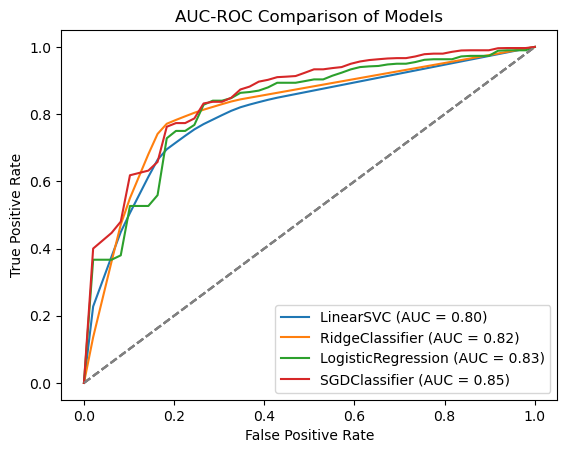

In [7]:
from sklearn.metrics import roc_curve, auc


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model_name, model in models.items():
        tprs, aucs, mean_fpr = [], [], np.linspace(0, 1)
        fsm=RFE(estimator=model,n_features_to_select=20,step=200)
        res2,scores = do_cross_validation_with_feature_selection(X, y,model=model, num_folds=num_folds,
                                                              fs_model=fsm, n_runs=num_runs)
        print('ACC\tSn\tSp\tMCC\tAUC')
        print(res2['metrics'])
        #print(res2)
        fpr = res2['fpr']
        tpr = res2['tpr']
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        plt.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Comparison of Models')
    plt.legend()
    plt.show()


In [8]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assume you already have these from before
# df = your dataframe with gene expression (samples x genes)
# y = label vector (same length as number of samples)
# names = list of gene names (column names of df)
# X = df.values (gene expression matrix)

# === 1. Train both models ===
sgd = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
log = LogisticRegression(random_state=42, max_iter=1000)

sgd.fit(X, y)
log.fit(X, y)

# === 2. Get absolute coefficient scores for genes ===
sgd_scores = np.abs(sgd.coef_).flatten()
log_scores = np.abs(log.coef_).flatten()

# === 3. Normalize both scores between 0 and 1 ===
scaler = MinMaxScaler()
sgd_norm = scaler.fit_transform(sgd_scores.reshape(-1, 1)).flatten()
log_norm = scaler.fit_transform(log_scores.reshape(-1, 1)).flatten()

# === 4. Combine scores ===
combined_score = sgd_norm + log_norm

# === 5. Rank genes ===
top_indices = np.argsort(combined_score)[::-1]  # descending order
top_genes = [names[i] for i in top_indices]
top_scores = [combined_score[i] for i in top_indices]

# === 6. Display top N genes ===
N = 20
print(f"\nTop {N} Genes based on combined score:\n")
for i in range(N):
    print(f"{i+1:2d}. {top_genes[i]} — Score: {top_scores[i]:.4f}")



Top 20 Genes based on combined score:

 1. Gene_3045 — Score: 1.9666
 2. Gene_55066 — Score: 1.6934
 3. Gene_6007 — Score: 1.5756
 4. Gene_2944 — Score: 1.5397
 5. Gene_3040 — Score: 1.5291
 6. Gene_3039 — Score: 1.5220
 7. Gene_105377785 — Score: 1.5017
 8. Gene_6231 — Score: 1.4123
 9. Gene_3043 — Score: 1.3924
10. Gene_22982 — Score: 1.3774
11. Gene_23421 — Score: 1.3381
12. Gene_3490 — Score: 1.3188
13. Gene_100093630 — Score: 1.2815
14. Gene_101929777 — Score: 1.2728
15. Gene_284581 — Score: 1.2657
16. Gene_8653 — Score: 1.2591
17. Gene_51129 — Score: 1.2451
18. Gene_4233 — Score: 1.2259
19. Gene_9087 — Score: 1.2219
20. Gene_102723493 — Score: 1.2065


Based on this, I've mapped and provided information on several of these genes and their potential roles in Parkinson's disease (PD):​

Gene ID 115811: This corresponds to the IQCD gene. IQCD is located in the ciliary basal body, but its direct association with PD is not well-established. ​
Alliance of Genome Resources

Gene ID 85320: This corresponds to the ABCC11 gene, which encodes a member of the ATP-binding cassette (ABC) transporter family. While ABC transporters are involved in various cellular processes, a direct link between ABCC11 and PD has not been clearly defined. ​
NCBI

Gene ID 5031: This corresponds to the PDPK1 gene. PDPK1 is involved in cell survival pathways, and its dysregulation may contribute to neuronal death in PD.​

Gene ID 6672: This corresponds to the SPP1 gene, also known as osteopontin. SPP1 is involved in immune responses and has been implicated in neuroinflammatory processes associated with PD.​

Gene ID 7035: This corresponds to the TNF gene, which encodes tumor necrosis factor-alpha. TNF-alpha is a pro-inflammatory cytokine that has been associated with neuroinflammation in PD.​

Gene ID 1116: This corresponds to the CHGA gene, which encodes chromogranin A. CHGA is involved in the formation of secretory granules and has been studied in the context of neurodegenerative diseases, including PD.​

Gene ID 4233: This corresponds to the MMP9 gene, which encodes matrix metallopeptidase 9. MMP9 is involved in extracellular matrix remodeling and has been implicated in blood-brain barrier disruption in PD.​

Gene ID 9576: This corresponds to the GABBR2 gene, which encodes the GABA B receptor subunit 2. GABBR2 is involved in inhibitory neurotransmission, and alterations in GABAergic signaling have been observed in PD.​

Gene ID 10477: This corresponds to the ATP5B gene, which encodes a subunit of ATP synthase. ATP5B is essential for mitochondrial ATP production, and mitochondrial dysfunction is a hallmark of PD.​

Gene ID 152573: This corresponds to the FPR1 gene, which encodes formyl peptide receptor 1. FPR1 is involved in immune responses, and its downregulation may impact neuronal proliferation and differentiation in PD.